Situation:
A new respiratory virus has begun circulating in another country. So far, epidemiological investigations have yielded the data below. What is an estimate for the average infection rate (the ‘beta’ parameter) for this disease? If a vaccine with 80% effectiveness becomes available before an epidemic begins in your own country, what is the minimum coverage of this vaccine, in order to prevent an outbreak from occurring?

Epidemiological data
All infected individuals go through an incubation period, which lasts on average for 4 days. During this time, individuals are not infectious, nor do they have any excess mortality risk.
All infected individuals eventually develop symptoms, and the mean duration of symptoms before recovery or death is 5 days. Symptomatic individuals are infectious, as well as having a 3% case fatality rate. Those who survive the infection are thought to have long-term immunity.
In the source country, the peak prevalence (i.e. maximum number of symptomatic people during the epidemic) was observed to be 8% of the population.
Assume that the source country and your own country are epidemiologically equivalent (i.e. that disease transmission follows the same parameters in both settings).
Details rundown:

incubation period lasts 4 days on average = delta is 4 **-1
mean duration of symptoms before recovery or death is 5 days = gamma is 5 **-1
Symptomatic individuals are infectious, as well as having a 3% case fatality rate = cfr is .03
peak prevalence 8% of the population
mortality rate mu is not provided, but we can derive this from gamma and cfr; use this to indicate excess mortality for infected
infection rate beta is not provided, so we need to solve for beta
vaccine with 80% effectiveness available before epidemic begins
what is the minimum coverage for this vaccine?

Case fatality rate is mu divided by mu + gamma, so let’s calculate mu based on a CFR of 3% and a gamma of .20:

                            cfr = mu/(mu + gamma);
     (cfr * mu) + (cfr * gamma) = mu;
                  (cfr * gamma) = mu - (cfr * mu);
                  (cfr * gamma) = mu * (1 - cfr);
        (cfr * gamma)/(1 - cfr) = mu;
          (.03 * .20)/(1 - .03) = mu;
                   (.006 / .97) = mu;
                    0.006185567 = mu;

In [6]:
library(deSolve)
library(reshape2)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [7]:
nicesubtitle <- "SEIR Model v1a1, respiratory virus with no vaccine c2w4_3"

In [8]:
print("initial state values and parameters")
# MODEL INPUTS:
N        <- 100     # population size
duration <- 80      # total number of days
tsteps   <- 0.1     # chunk in days  
beta     <- 4.1     # not provided -- infection rate day^-1
cfr      <- .03     # case fatality rate
gamma    <- 5 **-1 * (1 - cfr)  # recovery rate adjusted to 3% cfr
mu    <- 5 **-1 * (cfr) # excess mortality adjusted to 3% cfr
mu2       <- (cfr * gamma)/(1 - cfr)  # excess mortality calculated as per above
delta    <- 4 **-1  # incubation to infectious rate day^-1
R0 <- beta / gamma

(parameters <- c(
  beta = beta,    # infection rate
  gamma = gamma,  # recovery rate
  delta = delta,  # incubation rate
  mu = mu,        # mortality rate, simple calc
  mu2 = mu2,      # mortality rate, derived
  R0 = R0
  ))

[1] "initial state values and parameters"


beta    gamma    delta       mu      mu2       R0 
 4.10000  0.19400  0.25000  0.00600  0.00600 21.13402

In [9]:
# initial_state_values and times
initial_state_values <- c(S = (N-1),
                          E = 0, 
                          I = 1, 
                          R = 0)

# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SEIR MODEL FUNCTION 
seir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + E + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dE <- (lambda * S) -(delta * E)
      dI <- (delta * E) -(gamma * I) -(mu * I)
      dR <- (gamma * I)
      return(list(c(dS, dE, dI, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output3 <- as.data.frame(ode(y = initial_state_values, 
  times = times, 
  func = seir_model, 
  parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + E + I + R), digits=5) *100,
    propor_Exp = round(E/(S + E + I + R), digits=5) *100,
    preval_Inf = round(I/(S + E + I + R), digits=5) *100,
    propor_Re = round(R/(S + E + I + R), digits=5) *100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + E + I + R)),
    combo_E_I = E + I,
    perc_E_I = round(combo_E_I/(S + E + I + R), digits=5) *100,
    M_implied = N - (S + E + I + R)
    ) 

[1] "peak Infected day, calculated: "


In [ ]:
print("peak Infected day, calculated: ")
max(output3$I)/N

In [10]:
print("peak Infected day when I is at its max: ")
output3 %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak Infected day when I is at its max: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9.3,0.1536014,30.51291,37.92863,30.46271,0.155,30.803,38.289,30.752,0.03277089,68.44154,69.092,0.9421456


In [11]:
print("peak Infected day when preval_Inf % is at its max: ")
output3 %>%
  arrange(-preval_Inf, time) %>%
  head(1)

[1] "peak Infected day when preval_Inf % is at its max: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9.4,0.1312837,29.78158,37.92373,31.19851,0.133,30.072,38.293,31.502,0.02801584,67.70531,68.365,0.9649023


In [12]:
print("peak Exposed & Infected day when (E + I) is at its max: ")
output3 %>%
  arrange(-(E+I), time) %>%
  head(1)

[1] "peak Exposed & Infected day when (E + I) is at its max: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7,4.635936,48.93116,31.53323,14.45269,4.657,49.151,31.675,14.518,0.9841588,80.46438,80.826,0.4469904


In [13]:
print("point when R eff goes below 1: ")
output3 %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7,4.635936,48.93116,31.53323,14.45269,4.657,49.151,31.675,14.518,0.9841588,80.46438,80.826,0.4469904


In [14]:
print("last record for the run: ")
output3 %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
801,80,9.043305e-08,6.470519e-07,0.0001351099,96.99987,0,0,0,100,1.970324e-08,0.000135757,0,2.999996


[1] "Plotting the proportion of people in each compartment over time"


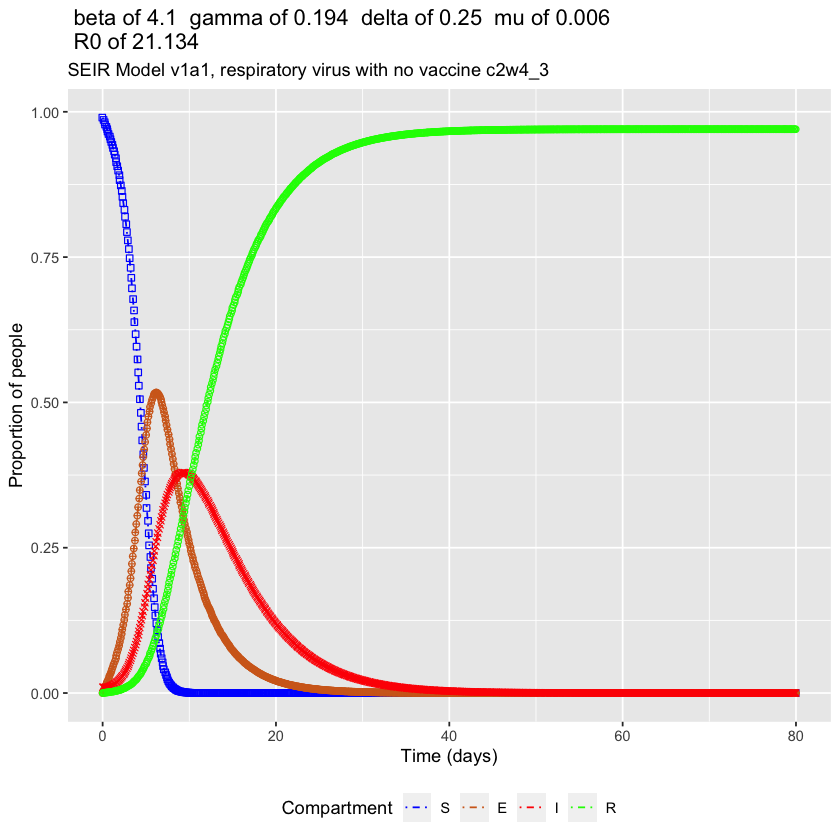

In [15]:
print("Plotting the proportion of people in each compartment over time")
output3 %>% 
  select(-still_Su, -propor_Exp, -preval_Inf, -propor_Re, -Reff,
    -combo_E_I, -perc_E_I, -M_implied) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","chocolate","red","green")) + 
  scale_shape_manual(values = c(0,10,4,1)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", round(parameters['gamma'],3),
    " delta of", round(parameters['delta'],3),
    " mu of", round(parameters['mu'],3),
    "\n R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

Create functions to seek appropriate beta for a peak infection rate of 8%


In [16]:
print("create a peak infection with closest value abs diff function, with some test runs")
# requires SEIR function from previous code chunk & prior parameters

# PEAKI FUNCTION (assumes seir_model model already loaded)
# parameters - vector with named elements for seir_model
SEIR_PEAKI <- function(parameters, peakval) {  
# MODEL OUTPUT (solving the differential equations):
oderesult2 <- as.data.frame(ode(y = initial_state_values,
  times = times,
  func = seir_model,
  parms = parameters))
peaki   <- max(oderesult2$I)/N
# return absolute difference between calculated peak value and provided constant peakval
return(abs(peaki - peakval))
}

# test 1 with peak in a variable 'parm' and no peakval ref 
SEIR_PEAKI(parameters =c(beta=4.1),peakval=0)

[1] "create a peak infection with closest value abs diff function, with some test runs"


[1] 0.3792863

In [17]:
# test 2 with peak in a variable 'parm' and no peakval ref 
SEIR_PEAKI(parameters =c(beta=4.5),peakval=0)


[1] 0.3825844

In [18]:
# test 3 with beta in a variable 'parm' and 8% peakval ref 
SEIR_PEAKI(parameters =c(beta=4.1),peakval=0.08)


[1] 0.2992863

In [19]:
# test 4 with beta in a variable 'parm' and 8% peakval ref 
SEIR_PEAKI(parameters =c(beta=1.8),peakval=0.08)

[1] 0.2467476

In [20]:
# Using optim() to find beta

# select upper limit of beta
betamax <- 80  

# choose values to start your optimisation
beta_start  <- .3  
peakval <- 0.08  
print("Using optim run 1 - No error code using L-BFGS-B method:")

[1] "Using optim run 1 - No error code using L-BFGS-B method:"


In [21]:
# run optim ver1
(optimised1 <- optim(par = c(beta = beta_start)
  , fn  = SEIR_PEAKI
  , peakval=peakval
  , method = "L-BFGS-B"
  ))

$par
     beta 
0.3826275 

$value
[1] 3.682028e-08

$counts
function gradient 
      58       58 

$convergence
[1] 52

$message
[1] "ERROR: ABNORMAL_TERMINATION_IN_LNSRCH"

In [22]:
print("Using optim run 2 - Warning on unreliability using Nelder-Mead method:")
## [1] "Using optim run 2 - Warning on unreliability using Nelder-Mead method:"
# run optim ver2
(optimised2 <- optim(par = c(beta = beta_start)
  , fn  = SEIR_PEAKI
  , peakval=peakval
  , method = "Nelder-Mead"
  ))

[1] "Using optim run 2 - Warning on unreliability using Nelder-Mead method:"


Warning message in optim(par = c(beta = beta_start), fn = SEIR_PEAKI, peakval = peakval, :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”


$par
     beta 
0.3826275 

$value
[1] 3.288581e-09

$counts
function gradient 
      48       NA 

$convergence
[1] 0

$message
NULL

In [23]:
print("Using optim run 2 - Warning on unreliability using Nelder-Mead method:")
## [1] "Using optim run 2 - Warning on unreliability using Nelder-Mead method:"
# run optim ver2
(optimised2 <- optim(par = c(beta = beta_start)
  , fn  = SEIR_PEAKI
  , peakval=peakval
  , method = "Nelder-Mead"
  ))

[1] "Using optim run 2 - Warning on unreliability using Nelder-Mead method:"


Warning message in optim(par = c(beta = beta_start), fn = SEIR_PEAKI, peakval = peakval, :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”


$par
     beta 
0.3826275 

$value
[1] 3.288581e-09

$counts
function gradient 
      48       NA 

$convergence
[1] 0

$message
NULL

In [31]:
# Using optimize() to find beta
# create hardocde 8 pct for single param optimize
SEIR_PEAK8 <- function(parameters) {  
# MODEL OUTPUT (solving the differential equations):
oderesult2 <- as.data.frame(ode(y = initial_state_values,
  times = times,
  func = seir_model,
  parms = parameters))
peaki   <- max(oderesult2$I)/N
# return absolute difference between calculated peak value and hardcoded 8% constant peakval
return(abs(peaki - .08))
}

(optimised3 <- optimize(SEIR_PEAK8, c(0.01,betamax), tol = 0.0001))

$minimum
[1] 79.99996

$objective
[1] 0.2992863

In [32]:
# check results

# test 5 using optim run 1 - no error code using L-BFGS-B
print(paste0("test 5 using optim run 1, minimize diff from 8% peak value with beta = ", 
             round(as.numeric(optimised1$par),6)))

[1] "test 5 using optim run 1, minimize diff from 8% peak value with beta = 0.382628"


In [33]:
SEIR_PEAKI(parameters =c(beta= as.numeric(optimised1$par)), peakval=0.08)

[1] 3.682028e-08

In [34]:
# test 6 using optim run 2 - warning using Nelder-Mead
print(paste0("test 6 using optim run 2, minimize diff from 8% peak value with beta = ",
             round(as.numeric(optimised2$par),6)))

[1] "test 6 using optim run 2, minimize diff from 8% peak value with beta = 0.382627"


In [35]:
SEIR_PEAKI(parameters =c(beta= as.numeric(optimised2$par)), peakval=0.08)

[1] 3.288581e-09

In [36]:
# test 7 using optimize run 3 - does not work?
print(paste0("test 7 using optimize run 3, minimize diff from 8% peak value with beta = ", 
             round(as.numeric(optimised3$minimum),6)))

[1] "test 7 using optimize run 3, minimize diff from 8% peak value with beta = 79.999965"


In [37]:
SEIR_PEAKI(parameters =c(beta= optimised3$minimum), peakval=0.08)

[1] 0.3285008

In [38]:
nicesubtitle <- "SEIR Model v1a2, respiratory virus with no vaccine c2w4_3"


In [39]:
(parameters <- c(
#  beta = .32, #new beta  
  beta = as.numeric(optimised1$par), #new beta  
  gamma = gamma,  # recovery rate
  delta = delta,  # incubation rate
  mu = mu,        # mortality rate, calculated
  R0 = as.numeric(optimised1$par) / gamma # recalc with new beta
  )) 

beta     gamma     delta        mu        R0 
0.3826275 0.1940000 0.2500000 0.0060000 1.9723068

In [40]:
# SEIR MODEL FUNCTION 
seir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + E + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dE <- (lambda * S) -(delta * E)
      dI <- (delta * E) -(gamma * I) -(mu * I)
      dR <- (gamma * I)
      return(list(c(dS, dE, dI, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output3 <- as.data.frame(ode(y = initial_state_values, 
  times = times, 
  func = seir_model, 
  parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + E + I + R), digits=5) *100,
    propor_Exp = round(E/(S + E + I + R), digits=5) *100,
    preval_Inf = round(I/(S + E + I + R), digits=5) *100,
    propor_Re = round(R/(S + E + I + R), digits=5) *100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + E + I + R)),
    combo_E_I = E + I,
    perc_E_I = round(combo_E_I/(S + E + I + R), digits=5) *100,
    M_implied = N - (S + E + I + R)
    ) 

print("peak Infected day, calculated: ")

[1] "peak Infected day, calculated: "


In [41]:
max(output3$I)/N

[1] 0.08000004

In [43]:
print("peak Infected day when I is at its max: ")
output3 %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak Infected day when I is at its max: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,47.8,48.42222,6.405023,8.000004,36.05757,48.968,6.477,8.09,36.464,0.9658052,14.40503,14.567,1.115183


In [44]:
print("peak Infected day when preval_Inf % is at its max: ")
output3 %>%
  arrange(-preval_Inf, time) %>%
  head(1)


[1] "peak Infected day when preval_Inf % is at its max: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,47.9,48.27255,6.394692,8,36.21278,48.819,6.467,8.091,36.623,0.9628668,14.39469,14.558,1.119983


In [45]:
print("peak Exposed & Infected day when (E + I) is at its max: ")
output3 %>%
  arrange(-(E+I), time) %>%
  head(1)

[1] "peak Exposed & Infected day when (E + I) is at its max: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,45.7,51.6643,6.574046,7.940363,32.80666,52.194,6.641,8.022,33.143,1.029423,14.51441,14.663,1.014639


In [46]:
print("point when R eff goes below 1: ")
output3 %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,46.7,50.09772,6.505256,7.98297,34.35163,50.636,6.575,8.069,34.721,0.998691,14.48823,14.644,1.062422


In [47]:
print("last record for the run: ")
output3 %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
801,80,24.61911,1.200934,2.228879,69.79254,25.162,1.227,2.278,71.332,0.4962768,3.429813,3.505,2.158532


[1] "Plotting the proportion of people in each compartment over time"


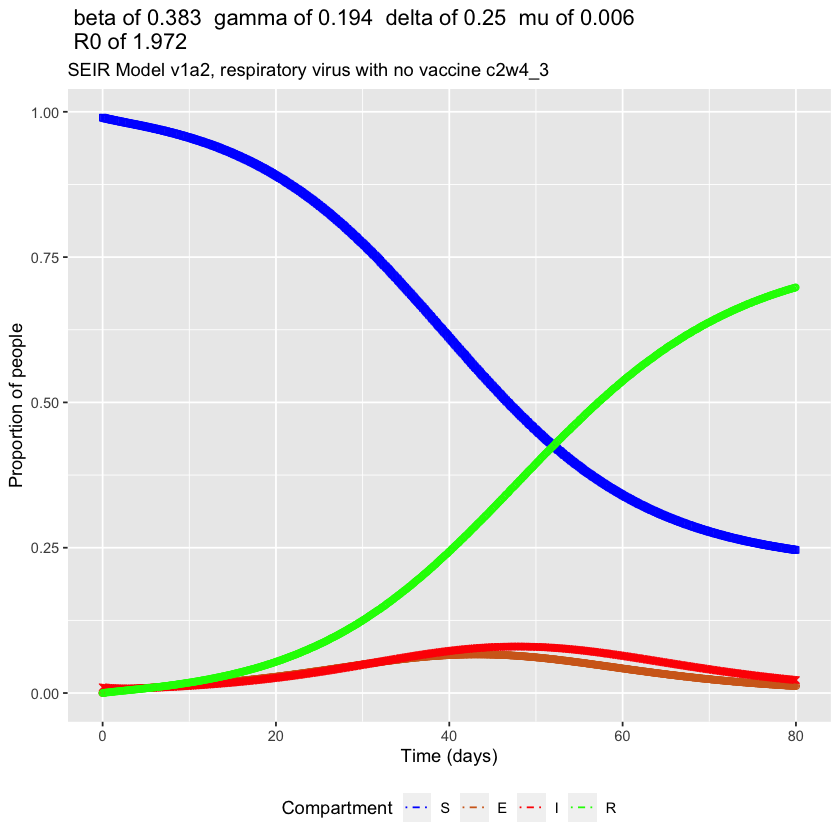

In [48]:
print("Plotting the proportion of people in each compartment over time")
## [1] "Plotting the proportion of people in each compartment over time"
output3 %>% 
  select(-still_Su, -propor_Exp, -preval_Inf, -propor_Re, -Reff,
    -combo_E_I, -perc_E_I, -M_implied) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","chocolate","red","green")) + 
  scale_shape_manual(values = c(0,10,4,1)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", round(parameters['beta'],3),
    " gamma of", round(parameters['gamma'],3),
    " delta of", round(parameters['delta'],3),
    " mu of", round(parameters['mu'],3),
    "\n R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")


In [49]:
nicesubtitle <- "SEIR Model v1a3, respiratory virus with partially effective vaccine c2w4_3"


In [51]:
# revise parameters
beta <- as.numeric(parameters["beta"]) # best attempt 
print("Critical Vaccine Threshold for perfect vaccine")
(pvacc_thresh <- 1 - as.numeric((gamma/parameters["beta"])))


[1] "Critical Vaccine Threshold for perfect vaccine"


[1] 0.4929795

In [52]:
R0 <- beta / gamma
veff     <- 0.80    # 80% vaccine effectiveness
print("revised threshold for 80% effective vaccine")
## [1] "revised threshold for 80% effective vaccine"
(pvacc_thresh <- (1 - (1/R0))/veff) # recalc results to consider efficacy

[1] "revised threshold for 80% effective vaccine"


[1] 0.6162244

In [53]:
pvacc <- pvacc_thresh # reset to effective

(parameters <- c(
  beta = beta,    # infection rate
  gamma = gamma,  # recovery rate
  delta = delta,  # incubation rate
  mu = mu,        # mortality rate, simple calc
  R0 = R0,
  veff = veff,
  pvacc = pvacc_thresh # reset to effective
  ))  

beta     gamma     delta        mu        R0      veff     pvacc 
0.3826275 0.1940000 0.2500000 0.0060000 1.9723068 0.8000000 0.6162244

In [54]:
# revise initial state values
# initial_state_values and times
initial_state_values <- 
  c(S = round((N-1) * (1-pvacc)),
    E = 0, 
    I = 1, 
    R = round((N-1) * (pvacc)))

# SEIR MODEL FUNCTION 
seir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + E + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dE <- (lambda * S) -(delta * E)
      dI <- (delta * E) -(gamma * I) -(mu * I)
      dR <- (gamma * I)
      return(list(c(dS, dE, dI, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output3 <- as.data.frame(ode(y = initial_state_values, 
  times = times, 
  func = seir_model, 
  parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + E + I + R), digits=5) *100,
    propor_Exp = round(E/(S + E + I + R), digits=5) *100,
    preval_Inf = round(I/(S + E + I + R), digits=5) *100,
    propor_Re = round(R/(S + E + I + R), digits=5) *100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + E + I + R)),
    combo_E_I = E + I,
    perc_E_I = round(combo_E_I/(S + E + I + R), digits=5) *100,
    M_implied = N - (S + E + I + R)
    ) 

In [56]:
print("peak Infected day, calculated: ")
max(output3$I)/N

[1] "peak Infected day, calculated: "


[1] 0.01

In [57]:
print("peak Infected day when I is at its max: ")
output3 %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak Infected day when I is at its max: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,38,0,1,61,38,0,1,61,0.7494766,1,1,0


In [58]:
print("peak Infected day when preval_Inf % is at its max: ")
output3 %>%
  arrange(-preval_Inf, time) %>%
  head(1)

[1] "peak Infected day when preval_Inf % is at its max: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,38,0,1,61,38,0,1,61,0.7494766,1,1,0


In [59]:
print("peak Exposed & Infected day when (E + I) is at its max: ")
output3 %>%
  arrange(-(E+I), time) %>%
  head(1)

[1] "peak Exposed & Infected day when (E + I) is at its max: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,38,0,1,61,38,0,1,61,0.7494766,1,1,0


In [60]:
print("point when R eff goes below 1: ")
output3 %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,38,0,1,61,38,0,1,61,0.7494766,1,1,0


In [61]:
print("last record for the run: ")
output3 %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


,time,S,E,I,R,still_Su,propor_Exp,preval_Inf,propor_Re,Reff,combo_E_I,perc_E_I,M_implied
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
801,80,35.72455,0.01941216,0.03001969,64.12924,35.759,0.019,0.03,64.191,0.7052803,0.04943185,0.049,0.09678061


[1] "Plotting the proportion of people in each compartment over time"


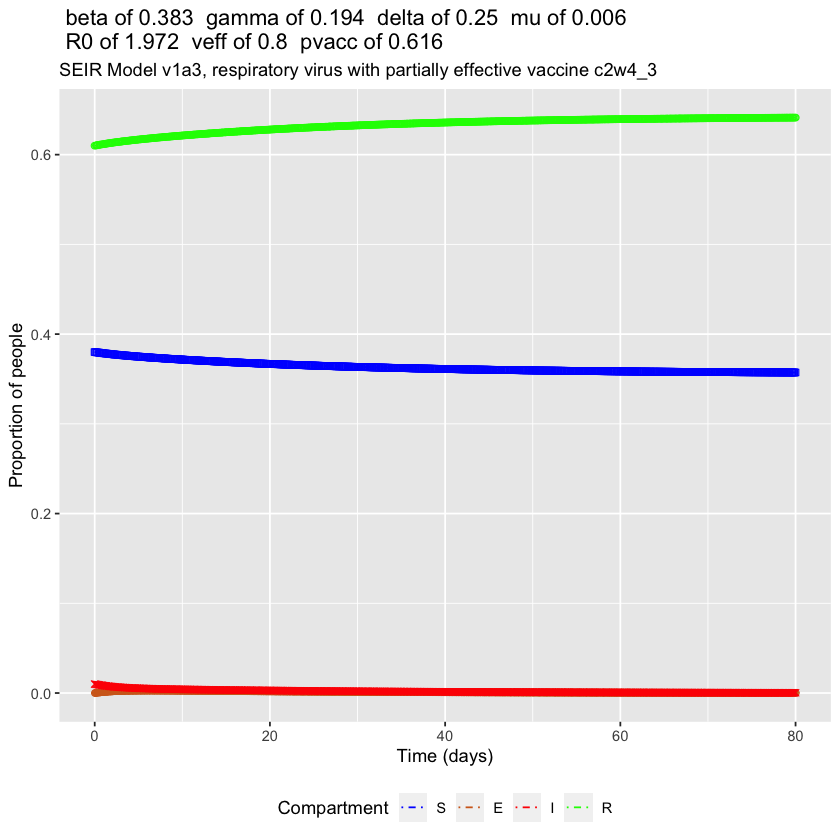

In [62]:
print("Plotting the proportion of people in each compartment over time")
## [1] "Plotting the proportion of people in each compartment over time"
output3 %>% 
  select(-still_Su, -propor_Exp, -preval_Inf, -propor_Re, -Reff,
    -combo_E_I, -perc_E_I, -M_implied) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","chocolate","red","green")) + 
  scale_shape_manual(values = c(0,10,4,1)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", round(parameters['beta'],3),
    " gamma of", round(parameters['gamma'],3),
    " delta of", round(parameters['delta'],3),
    " mu of", round(parameters['mu'],3),
    "\n R0 of", round(parameters['R0'],3),
    " veff of", round(parameters['veff'],3),
    " pvacc of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")
